# Import appropriate modules

In [1]:
import numpy as np
from numpy.linalg import eigh
from numpy import load
np.set_printoptions(threshold=np.inf, linewidth=np.inf)
np.set_printoptions(formatter={'float': lambda x: "{0:0.3e}".format(x)})

import diatom.hamiltonian as hamiltonian
import diatom.calculate as calculate
from diatom.constants import Rb87Cs133

import scipy.constants
from scipy.linalg import expm

import matplotlib.pyplot as plt
import matplotlib.colors
from matplotlib.gridspec import GridSpec

from tqdm import tqdm, trange
import math
import itertools

# plt.rcParams["text.usetex"] = True
plt.rcParams["font.family"] = 'sans-serif'
plt.rcParams["figure.autolayout"] = True
plt.rcParams['figure.figsize'] = (4, 3.5)
plt.rcParams['figure.dpi'] = 200
# plt.rc('text.latex', preamble=r'\usepackage[T1]{fontenc}\usepackage{cmbright}\usepackage{mathtools}')

%matplotlib widget
%config InlineBackend.figure_format = 'retina'

## Defining parameters

In [4]:
MOLECULE_STRING = "Rb87Cs133"
MOLECULE = Rb87Cs133
N_MAX=2

PULSE_TIME_US = 500 #μs

settings_string = f'{MOLECULE_STRING}NMax{N_MAX}PTime{PULSE_TIME_US}'
print(settings_string)

H_BAR = scipy.constants.hbar
muN = scipy.constants.physical_constants['nuclear magneton'][0]

I1 = MOLECULE["I1"]
I2 = MOLECULE["I2"]
I1_D = round(2*I1)
I2_D = round(2*I2)

D_0 = MOLECULE["d0"]

PER_MN = round((2*I1+1)*(2*I2+1))
N_STATES = PER_MN * (N_MAX+1)**2
print(f"{N_STATES} states loaded from molecule.")

GAUSS = 1e-4 # T
PULSE_TIME = PULSE_TIME_US * 1e-6 # s

B_NOISE = 35 * 1e-3 * GAUSS

# B, B_STEP_SIZE = np.linspace(B_MIN, B_MAX, B_STEPS, retstep=True) #T 

Rb87Cs133NMax2PTime500
288 states loaded from molecule.


In [5]:
print("Loading precomputed data...")
data = np.load(f'../precomputed/{settings_string}.npz')

B=data['b']
B_MIN = B[0]
B_MAX = B[-1]
B_STEPS = len(B)

ENERGIES = data['energies']
STATES = data['states']

LABELS_D=data['labels_d']
UNCOUPLED_LABELS_D=data['uncoupled_labels_d']

MAGNETIC_MOMENTS=data['magnetic_moments'] 

COUPLINGS_ZERO=data['couplings_zero']
COUPLINGS_MINUS=data['couplings_minus']
COUPLINGS_PLUS=data['couplings_plus']
COUPLINGS = COUPLINGS_ZERO+COUPLINGS_MINUS+COUPLINGS_PLUS
POLARISED_COUPLING = [COUPLINGS_ZERO,COUPLINGS_PLUS,COUPLINGS_MINUS]

UNPOLARISED_PAIR_FIDELITIES = data['unpolarised_pair_fidelities_ut']
UNPOLARISED_PAIR_FIDELITIES = UNPOLARISED_PAIR_FIDELITIES + UNPOLARISED_PAIR_FIDELITIES.transpose(1,0,2)
POLARISED_PAIR_FIDELITIES = data['polarised_pair_fidelities_ut']
POLARISED_PAIR_FIDELITIES = POLARISED_PAIR_FIDELITIES + POLARISED_PAIR_FIDELITIES.transpose(1,0,2)
print("Precomuted data loaded.")

Loading precomputed data...
Precomuted data loaded.


## Computed Constants

In [6]:
# H_BAR = scipy.constants.hbar
# muN = scipy.constants.physical_constants['nuclear magneton'][0]

# I1 = MOLECULE["I1"]
# I2 = MOLECULE["I2"]
# I1_D = round(2*I1)
# I2_D = round(2*I2)

# D_0 = MOLECULE["d0"]

# PER_MN = round((2*I1+1)*(2*I2+1))
# N_STATES = PER_MN * (N_MAX+1)**2

# GAUSS = 1e-4 # T
# B_MIN = B_MIN_GAUSS * GAUSS # T
# B_MAX = B_MAX_GAUSS * GAUSS # T
# PULSE_TIME = PULSE_TIME_US * 1e-6 # s

# B, B_STEP_SIZE = np.linspace(B_MIN, B_MAX, B_STEPS, retstep=True) #T 

# Load precomputed results

In [7]:
data = np.load(f'../precomputed/{settings_string}.npz')

ENERGIES = data['energies']
STATES = data['states']

LABELS_D=data['labels_d']
UNCOUPLED_LABELS_D=data['uncoupled_labels_d']

MAGNETIC_MOMENTS=data['magnetic_moments'] 

COUPLINGS_ZERO=data['couplings_zero']
COUPLINGS_MINUS=data['couplings_minus']
COUPLINGS_PLUS=data['couplings_plus']
COUPLINGS = COUPLINGS_ZERO+COUPLINGS_MINUS+COUPLINGS_PLUS
POLARISED_COUPLING = [COUPLINGS_ZERO,COUPLINGS_PLUS,COUPLINGS_MINUS]

UNPOLARISED_PAIR_FIDELITIES = data['unpolarised_pair_fidelities_ut']
UNPOLARISED_PAIR_FIDELITIES = UNPOLARISED_PAIR_FIDELITIES + UNPOLARISED_PAIR_FIDELITIES.transpose(1,0,2)
POLARISED_PAIR_FIDELITIES = data['polarised_pair_fidelities_ut']
POLARISED_PAIR_FIDELITIES = POLARISED_PAIR_FIDELITIES + POLARISED_PAIR_FIDELITIES.transpose(1,0,2)

# Helper Functions

In [8]:
def label_to_state_no(N,MF_D,k):
    return np.where((LABELS_D[:, 0] == N) & (LABELS_D[:, 1] == MF_D) & (LABELS_D[:, 2] == k))[0][0]

def state_no_to_uncoupled_label(state_no):
    return UNCOUPLED_LABELS_D[state_no]

In [9]:
def label_d_to_string(label_d):
    n = label_d[0]
    mf_d = label_d[1]
    mf_frac = mf_d%2
    i = label_d[2]
    if mf_frac == 0:
        return f"({n},{mf_d//2},{i})"
    else:
        mf_whole= (mf_d - np.sign(mf_d))//2
        return f"({n},{mf_whole}.5,{i})"

def label_d_to_latex_string(label_d):
    n = label_d[0]
    mf_d = label_d[1]
    mf_frac = mf_d%2
    i = label_d[2]
    if mf_frac == 0:
        return r'|{},{}\rangle_{{{}}}'.format(n,mf_d//2,i)
    else:
        mf_whole= (mf_d - np.sign(mf_d))//2
        return r'|{},{}.5\rangle_{{{}}}'.format(n,mf_whole,i)

In [10]:
def label_degeneracy(N,MF_D):
    # Want number of ways of having
    # MF = MN + (M_I1 + M_I2) # NP-Hard Problem SSP (Subset Sum)
    d=0
    for MN in range(-N,N+1):
        for M_I1_D in range(-I1_D,I1_D+1,2):
            for M_I2_D in range(-I2_D,I2_D+1,2):
                if 2*MN+M_I1_D+M_I2_D == MF_D:
                    d+=1
    return d

In [11]:
def twice_average_fidelity(k,g):
    return ((1 + g**2)**2 + 8*k**2*(-1 + 2*g**2) + 16*k**4)/((1 + g**2)**3 + (-8 + 20*g**2 + g**4)*k**2 + 16*k**4)

def simple_fidelity(k,g):
    return 1-np.abs(g)**2/np.abs(k)**2

def maximum_fidelity(k,g):
    phi = np.arccos((k*(18-9*g**2-8*k**2))/(3+3*g**2+4*k**2)**(3/2))/3
    denominator = 54*((1+g**2)**3+(-8+20*g**2+g**4)*k**2+16*k**4)
    numerator = (
                 36*(g**4+(1-4*k**2)**2+2*g**2*(1+8*k**2))
               + 32*k    *(3+3*g**2+4*k**2)**(3/2) *np.cos(phi)
               - 64*k**2 *(3+3*g**2+4*k**2)        *np.cos(2*phi) 
               -  4      *(3+3*g**2+4*k**2)**2     *np.cos(4*phi)
                )
    return numerator/denominator

def fidelity(ts,d=8):
    return -np.log10(1-ts+10**(-d))

In [12]:
def find_nearest(array,value):
    idx = np.searchsorted(array, value, side="left")
    if idx > 0 and (idx == len(array) or math.fabs(value - array[idx-1]) < math.fabs(value - array[idx])):
        return idx-1
    else:
        return idx

def field_to_bi(gauss):
    return find_nearest(B,gauss*GAUSS)

# Simulator

In [71]:
# Driven couplings between states
chosen_states_coupling_labels = np.array([(0,-10,0),(1,-8,5),(2,-8,9),(1,-10,0)])
chosen_coupling_labels = [
    (chosen_states_coupling_labels[0],chosen_states_coupling_labels[1]),
    (chosen_states_coupling_labels[1],chosen_states_coupling_labels[2]),
    (chosen_states_coupling_labels[3],chosen_states_coupling_labels[2]),
    (chosen_states_coupling_labels[0],chosen_states_coupling_labels[3]),
]

# With what desired rabi period
global_pulse_time = 6.389 * 10**(4/2) * 1e-6 #s
chosen_pulse_time = [global_pulse_time]*4

# At what magnetic field
chosen_bi = field_to_bi(58)

# Only simulate other states that have strong off resonant coupling
cutoff = 0.9999999999 # =0 for only these =1 for all states
        
# Simulation resolution
T_STEPS =  [803989,314927,195931,65519,41443,21319,9391,50][0] 

# Simulation time length (how many Rabi periods to show)
TIME = chosen_pulse_time[0]*2

In [72]:
example_points = []

if cutoff == 0:
    chosen_states_labels = chosen_states_coupling_labels
elif cutoff == 1:
    chosen_states_labels = LABELS_D
else:
    needed_states = np.full(N_STATES, False)
    for (al,bl),pt in zip(chosen_coupling_labels, chosen_pulse_time):
        ai = label_to_state_no(*al)
        bi = label_to_state_no(*bl)
        ks_up = np.abs((ENERGIES[chosen_bi, :] - ENERGIES[chosen_bi, bi, None]) * pt / scipy.constants.h)
        ks_down = np.abs((ENERGIES[chosen_bi, :] - ENERGIES[chosen_bi, ai, None]) * pt / scipy.constants.h)

        gs_unpolarised_up = np.abs(COUPLINGS[chosen_bi, ai, :]/COUPLINGS[chosen_bi, ai, bi])
        gs_unpolarised_down = np.abs(COUPLINGS[chosen_bi, bi, :]/COUPLINGS[chosen_bi, ai, bi])
        
        for k_up,g_unpolarised_up in zip(ks_up,gs_unpolarised_up):
            example_points.append((k_up,g_unpolarised_up,1))
        for k_down,g_unpolarised_down in zip(ks_down,gs_unpolarised_down):
            example_points.append((k_down,g_unpolarised_down,1))

        fidelities_unpolarised_up = twice_average_fidelity(ks_up,gs_unpolarised_up)
        fidelities_unpolarised_down = twice_average_fidelity(ks_down,gs_unpolarised_down)
        
        fidelities_unpolarised_up_simple = simple_fidelity(ks_up,gs_unpolarised_up)
        fidelities_unpolarised_down_simple = simple_fidelity(ks_down,gs_unpolarised_down)
        
        print(fidelities_unpolarised_up[fidelities_unpolarised_up<0.99999999],fidelities_unpolarised_down[fidelities_unpolarised_down<0.99999999])
        print(fidelities_unpolarised_up_simple[fidelities_unpolarised_up_simple<0.99999999],fidelities_unpolarised_down_simple[fidelities_unpolarised_down_simple<0.99999999])
        print(np.prod(fidelities_unpolarised_up)*np.prod(fidelities_unpolarised_down)*4)
        print(np.prod(np.clip(fidelities_unpolarised_up_simple,0.5,1))*np.prod(np.clip(fidelities_unpolarised_down_simple,0.5,1))*4)
        print('----')
        
        needed_states = needed_states + (fidelities_unpolarised_up < cutoff) + (fidelities_unpolarised_down < cutoff)
        chosen_states_labels = LABELS_D[needed_states]
    print(f"These states passed the cutoff ({cutoff}):")
    print(chosen_states_labels)
    
chosen_states_coupling_subindices = [np.where((chosen_states_labels[:, 0] == N) & (chosen_states_labels[:, 1] == MF) & (chosen_states_labels[:, 2] == k))[0][0] for N,MF,k in chosen_states_coupling_labels]
chosen_states_indices = np.array([label_to_state_no(*label) for label in chosen_states_labels])
chosen_number_of_states = len(chosen_states_indices)

[1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 9.999e-01 5.000e-01] [1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 5.000e-01]
[1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 9.999e-01 1.000e+00 9.999e-01 9.996e-01 -inf] [1.000e+00 1.000e+00 1.000e+00 1.000e+00 9.999e-01 -inf]
0.999801669453521
0.9993616205509244
----
[1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 5.000e-01 9.998e-01] [1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 5.000e-01]
[1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 9.999e-01 1.000e+00 1.000e+00 1.000e+00 -inf 9.994e-01] [1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+0

/var/folders/lt/2lfqhmyn1n9bbwg1sqf3zzwc0000gn/T/ipykernel_82558/2130079386.py:5: RuntimeWarning: divide by zero encountered in divide
  return 1-np.abs(g)**2/np.abs(k)**2


In [73]:
# Compute further constants and indices from molecular parameters
k_exp_range = (-7,7)
g_exp_range = (-7,7)
ks = np.logspace(*k_exp_range,1000)
gs = np.logspace(*g_exp_range,1000)
ks, gs = np.meshgrid(ks,gs)
twice_average_fidelities = twice_average_fidelity(ks,gs)
simple_fidelities = simple_fidelity(ks,gs)

/var/folders/lt/2lfqhmyn1n9bbwg1sqf3zzwc0000gn/T/ipykernel_82558/387071767.py:1: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, (axl,axr) = plt.subplots(1,2,figsize=(6,3),constrained_layout=True,sharex=True,sharey=True)
/var/folders/lt/2lfqhmyn1n9bbwg1sqf3zzwc0000gn/T/ipykernel_82558/387071767.py:15: RuntimeWarning: invalid value encountered in log10
  normalised_fidelies = (np.log10(1/(1 - (1 - 10**(-k))*fidelities - 0.5*10**(-k)) - 1))/(2*np.log10(2*10**k - 1)) + 1/2


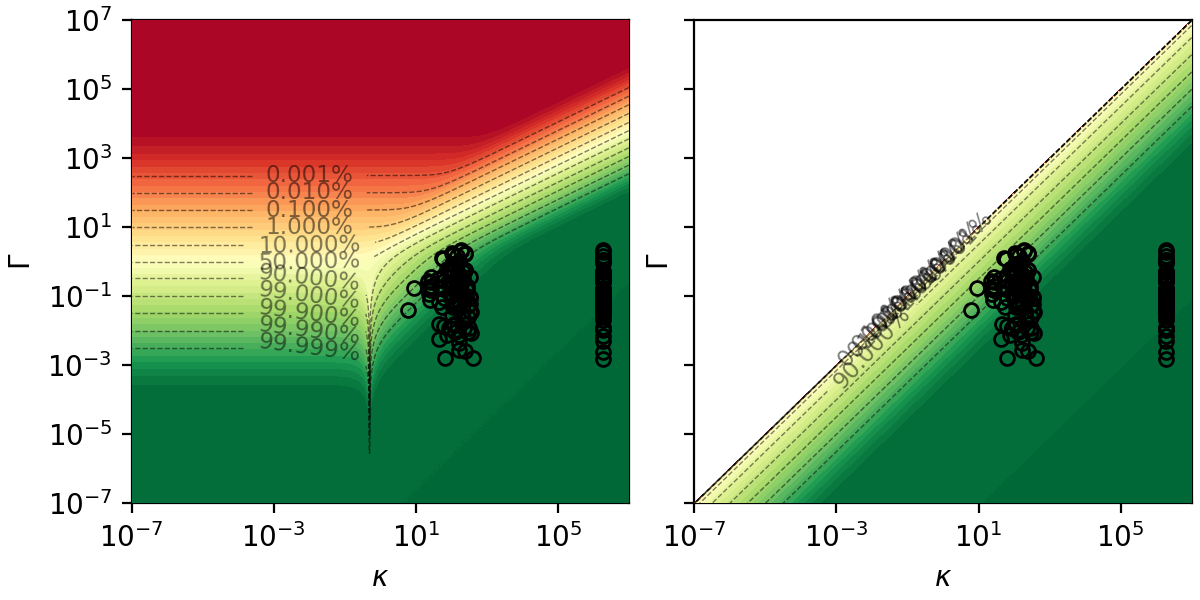

In [74]:
fig, (axl,axr) = plt.subplots(1,2,figsize=(6,3),constrained_layout=True,sharex=True,sharey=True)

Norm  = matplotlib.colors.Normalize(vmin=0, vmax=1)

noted_levels=[0.00001,0.0001,0.001,0.01,0.1,0.5,0.9,0.99,0.999,0.9999,0.99999]

for ax, fidelities in [(axl,twice_average_fidelities),(axr,simple_fidelities)]:
    ax.set_ylabel('$\Gamma$')
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlim(10**k_exp_range[0],10**k_exp_range[1])
    ax.set_ylim(10**g_exp_range[0],10**g_exp_range[1])
    ax.set_xlabel('$\kappa$')
    k=7
    normalised_fidelies = (np.log10(1/(1 - (1 - 10**(-k))*fidelities - 0.5*10**(-k)) - 1))/(2*np.log10(2*10**k - 1)) + 1/2
    cf = ax.contourf(ks,gs,normalised_fidelies,40,cmap='RdYlGn',norm=Norm,alpha=1,zorder=10)
    CS1 = ax.contour(ks,gs,fidelities,noted_levels, colors='k',linestyles='dashed',linewidths=0.5,alpha=0.5,zorder=20)

    fmt = {}
    strs = [f"{n*100:.3f}%" for n in noted_levels]
    for l, s in zip(CS1.levels, strs):
        fmt[l] = s

    labelpositions = [(0.01,np.sqrt(1/n-1)) for n in noted_levels]
    ax.clabel(CS1, CS1.levels, fmt=fmt,manual=labelpositions,fontsize='small')

    for k,g,_ in example_points:
        ax.plot(k, g, 'ko',markersize=5,zorder=100,mfc='none')

In [78]:
# Get Angular Frequency Matrix Diagonal for each B
all_angular = ENERGIES[chosen_bi, :].real / H_BAR # [state]
angular = all_angular[chosen_states_indices]

all_couplings = COUPLINGS[chosen_bi]
couplings = all_couplings[:,chosen_states_indices][chosen_states_indices,:]

# Get driving frequencies & polarisations
driving = []
E_i = []
for (l1,l2), pulse_time in zip(chosen_coupling_labels, chosen_pulse_time):
    i1=label_to_state_no(*l1)
    i2=label_to_state_no(*l2)
    driving.append(np.abs(all_angular[i1]-all_angular[i2]))
    E_i.append((2*np.pi*H_BAR) / (D_0 * all_couplings[i1,i2] * pulse_time))
driving = np.array(driving)
print("Driving (rad/s):", driving)
E_i = np.array(E_i,dtype=np.double)
print("E (V/m):", E_i)

# Construct times
times, DT = np.linspace(0,TIME,num=T_STEPS,retstep=True)

# Construct kinetic time step operator (Matrix Diagonal)
T_OP_DIAG = np.exp(-(1j) * angular * DT/2 )

# Construct potential fixed part time step operator 
ORDER = 10
V_TI_M = (-(1j)*D_0*couplings*DT)/H_BAR
V_TI_M_POWS = np.array([np.linalg.matrix_power(V_TI_M, i)/np.math.factorial(i) for i in range(ORDER)])

# Construct state vector
state_vector = np.zeros((T_STEPS,chosen_number_of_states), dtype=np.cdouble)
state_vector[0,chosen_states_coupling_subindices[0]] = np.sqrt(1)
state_vector[0,chosen_states_coupling_subindices[0]] = np.sqrt(1)

for t_num in trange(T_STEPS-1):
    pres = E_i*np.cos(driving*times[t_num])
    V_TD_POWS = np.sum(pres)**(np.arange(ORDER))
    V_OP = np.sum(V_TI_M_POWS*V_TD_POWS[:,None,None],axis=0)
    
    DU = T_OP_DIAG[:,None] * V_OP[:,:] * T_OP_DIAG[None,:]
    state_vector[t_num+1] = DU @ state_vector[t_num]

resolution=20
probabilities = np.abs(state_vector[::resolution,:])**2

/var/folders/lt/2lfqhmyn1n9bbwg1sqf3zzwc0000gn/T/ipykernel_82558/3759703703.py:18: ComplexWarning: Casting complex values to real discards the imaginary part
  E_i = np.array(E_i,dtype=np.double)


Driving (rad/s): [6.161e+09 1.232e+10 1.232e+10 6.158e+09]
E (V/m): [5.159e-01 -5.632e-01 -9.647e-01 9.191e-01]


100%|████████████████████████████████| 803988/803988 [01:08<00:00, 11791.37it/s]


0.24987022061779363


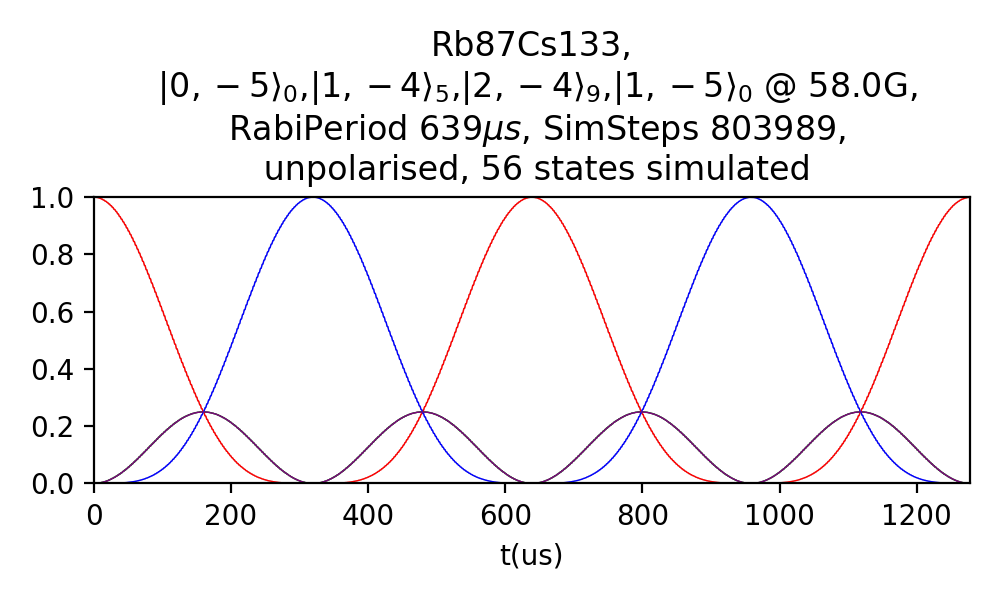

In [79]:
# Plot results
fig,ax = plt.subplots(figsize=(5,3))
ax.set_xlabel('t(us)')
ax.set_ylim(0,1)
ax.set_xlim(0,TIME*1e6)
states_string = ','.join([f'${label_d_to_latex_string(label)}$' for label in chosen_states_coupling_labels])
ax.set_title('{},\n {} @ {}G,\n RabiPeriod {}$\mu s$, SimSteps {},\n unpolarised, {} states simulated'
             .format(MOLECULE_STRING,
                     states_string,
                     f"{B[chosen_bi]/GAUSS:.1f}",
                     round(global_pulse_time*1e6),
                     T_STEPS,
                     chosen_number_of_states))

c = ['red','green','blue','purple']
ax.plot(times[::resolution]*1e6,probabilities[:,:],c='grey',linewidth=0.5,alpha=0.5);
for i,state_subindex in enumerate(chosen_states_coupling_subindices):
    ax.plot(times[::resolution]*1e6,probabilities[:,state_subindex],c=c[i],linewidth=0.5);
    
print(np.max(probabilities[:,state_subindex]))
fig.savefig(f'../images/{MOLECULE_STRING}-2-state-qubit-sim-a.pdf')

# 0.9648965433180197
# 0.9832076055653106


# 0.9961902824155995 
# 0.9995866883277325
# 0.9999598833175668
# 0.9999959365463854